# CHORDS data manipulation in Python

In [1]:
import requests

# 1. connect to CHORDS for data

Opening the api key is critical for data retrieval.  Put your API key and email in a file called `api-key.txt` in a **single line** that looks like this:

```csv
490rieojfdn8e,youremail@yourdomain.com
```

Notice the comma seperates the key from the email address.

In [2]:
with open("api-key.txt") as f:
    api_key, email = f.read().split(",")

Next we will use the [Python Requests](https://docs.python-requests.org/en/latest/index.html) library to perform an HTTP/GET and store the response in a file:

In [3]:
r = requests.get(f"http://3d.chordsrt.com/api/v1/data/7.csv?start=2023-03-20T00:00&end=2023-03-30T00:00&api_key={api_key}&email={email}")
if r.status_code == 200:
    with open("sample_data.csv", "w") as fo:
        fo.write(r.text)
    print("[info] payload saved.")
else:
    print(r.json())

[info] payload saved.


**NOTE:** Details about the the CHORDS API calls can be found here:

* [http://3d.chordsrt.com/about/data_urls?instrument_id=7](http://3d.chordsrt.com/about/data_urls?instrument_id=7)

# 2. review the data

Since the output was a CSV file, we can open it right here.

# 3. open the data in Python

We will use the [Pandas library](https://pandas.pydata.org/) to load the data into a [DataFrame]().

In [4]:
import pandas as pd
df = pd.read_csv("sample_data.csv", comment="#")

The [`head()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html)  returns the top 5 rows of the DataFrame

In [5]:
df.head()

,Time,HTU21D_T,HTU21D_RH,BMP180_SLP,BMP180_SP,BMP180_T,MCP9808,windspeed,winddirection,precipitation,SI1145_VIS,SI1145_IR,SI1145_UV
0,2023-03-20T00:00:01Z,NaN,NaN,NaN,NaN,NaN,NaN,7.92,NaN,NaN,NaN,NaN,NaN
1,2023-03-20T00:00:04Z,NaN,NaN,1008.96,819.8,9.4,9.7,NaN,NaN,NaN,384.0,1807.0,68.0
2,2023-03-20T00:00:05Z,9.6,17.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-03-20T00:01:02Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232.7,NaN,NaN,NaN,NaN
4,2023-03-20T00:01:09Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


To take advantage of Pandas' ability to work with [time series data](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html), we will set the index of our date to the `Time` column, which will greatly improve our ability to plot, select and manipulate the data based on times/dates.

In [6]:
df = df.set_index('Time')

In [7]:
df.head()

,HTU21D_T,HTU21D_RH,BMP180_SLP,BMP180_SP,BMP180_T,MCP9808,windspeed,winddirection,precipitation,SI1145_VIS,SI1145_IR,SI1145_UV
Time,,,,,,,,,,,,
2023-03-20T00:00:01Z,NaN,NaN,NaN,NaN,NaN,NaN,7.92,NaN,NaN,NaN,NaN,NaN
2023-03-20T00:00:04Z,NaN,NaN,1008.96,819.8,9.4,9.7,NaN,NaN,NaN,384.0,1807.0,68.0
2023-03-20T00:00:05Z,9.6,17.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-20T00:01:02Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232.7,NaN,NaN,NaN,NaN
2023-03-20T00:01:09Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


As we can see there are a lot of empty values (`NaN`).  And a variety of data points we do not need -- we are only interested in the non-empty data and for the sake of this notebook the `HTU21D_T` column which includes temperature data in Celsius.

We'll select just that column by it's name and also drop any empty values as they are not important to this analysis.

In [8]:
df['HTU21D_T'].dropna()

Time
2023-03-20T00:00:05Z    9.6
2023-03-20T00:01:11Z    9.5
2023-03-20T00:02:04Z    9.7
2023-03-20T00:03:04Z    9.8
2023-03-20T00:04:07Z    9.8
                       ... 
2023-03-29T23:55:04Z    4.7
2023-03-29T23:56:08Z    4.7
2023-03-29T23:57:05Z    4.7
2023-03-29T23:58:05Z    4.7
2023-03-29T23:59:06Z    4.7
Name: HTU21D_T, Length: 14233, dtype: float64

In [9]:
temp = df['HTU21D_T'].dropna()

You will notice all the temperature data is in C.  We will create a little function to convert it to F.

Remember the formula to make this conversion:

$$
F =  \frac{9}{5} \times C  + 32
$$

like this:

In [10]:
def to_F(celsius):
    return 9/5 * celsius + 32

In [11]:
# test
to_F(0)

32.0

Now we will update the data ... the [`apply()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) will take our function and apply it to the entire column (or DataFrame, if we want).  This makes is very simple to get the data in the shape we would like it.

In [12]:
temp = temp.apply(to_F) # convert data to F

Plotting is simple, now that we have all the data we need.

<AxesSubplot:title={'center':'NCAR Testbed 2\nMar-20 to Mar-30 temperatures (F)'}, xlabel='Time'>

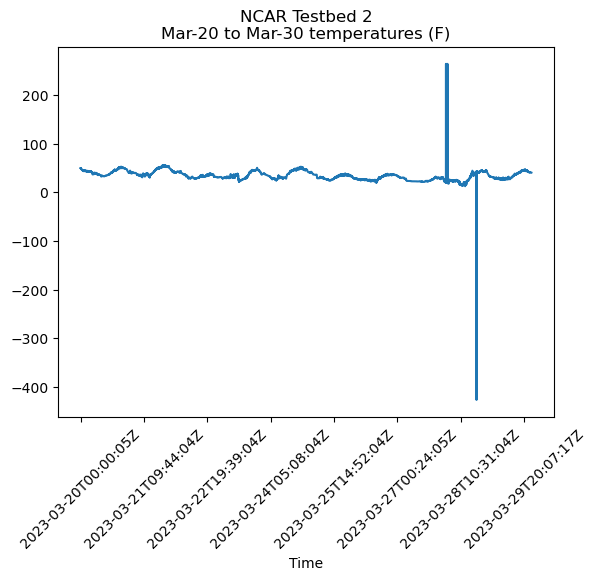

In [13]:
temp.plot(title="NCAR Testbed 2\nMar-20 to Mar-30 temperatures (F)", rot=45)

## What is the Average Temperature?

In [14]:
temp.mean()

34.356428019392105

## What is the Highest and Lowest Temperatures?

In [15]:
temp.max(), temp.min()

(264.02000000000004, -427.0)

That's weird?  Looks like the sensor **went crazy one day**!

Now you can study the Pandas documentation to learn how to clean the data and eliminate those outliers!

$\Xi$